In [1]:
from utils import *
from wrapper import *
import matplotlib
import matplotlib.pyplot
import scipy.io as sio
from einops import rearrange
torch.set_num_threads(os.cpu_count())
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_path = './kspc_volN1.mat'
data = sio.loadmat(data_path)
kspc = data['kspc']
csm = data['smaps']

kspc = rearrange(kspc, 'FE PE SPE Nt Nv Nc -> Nv Nt Nc FE PE SPE')
csm = rearrange(csm, 'FE PE SPE Nc -> Nc FE PE SPE')
sos = np.sqrt(np.sum(np.abs(csm) ** 2, axis=0, keepdims=True)) + 1e-11
csm /= sos
Nv, Nt, Nc, FE, PE, SPE = kspc.shape

In [2]:
img_llr = ReconLLR(kspc, csm, reg=1e-2, blk=8, itmethod='POGM', it=200, Lc=1., device='cuda:0', verbose=0, stopth=1e-4).cpu().numpy()
# img_llr = ReconLLR(kspc[0:1], csm, reg=1e-2, blk=8, itmethod='POGM', it=200, Lc=1., device='cuda:0', verbose=0, stopth=1e-4).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 13%|█▎        | 26/200 [00:34<03:51,  1.33s/it, loss=18814.77734, loss_DC=14072.03711, loss_LR=4742.74023]


In [3]:
img_ls = ReconLplusS(kspc, csm, regL=1e-2, regS=1e-2, blk=8, HADAMARD=1, itmethod='POGM', it=200, Lc=2., device='cuda:0', verbose=0, stopth=1e-4).cpu().numpy()
# img_ls = ReconLplusS(kspc[0:1], csm, regL=1e-2, regS=1e-2, blk=8, HADAMARD=1, itmethod='POGM', it=200, Lc=2., device='cuda:0', verbose=0, stopth=1e-3).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 28%|██▊       | 55/200 [01:12<03:11,  1.32s/it, loss=22044.31804, loss_DC=9708.90723, loss_LR=74.94831, loss_S=12260.46250]  


In [4]:
regt = 0.01
regs = 0.001
img_haar = ReconHAAR(kspc, csm, 
                reg_list = np.array([regt, regt, regt, regt, regt, regt, regt, regt, regs, regs, regs, regs, regs, regs, regs, 1e-2*regs]),
                itmethod='POGM', it=200, Lc=1., device='cuda:0', verbose=0, stopth=1e-4).cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 36%|███▌      | 71/200 [00:21<00:38,  3.38it/s, loss=23145.05441, loss_DC=10499.14844, loss_H=12645.90598]


In [7]:
regt, regs = 0.01, 0.001
img_core, v = ReconHAAR_CORE(kspc, csm,  
                            gStp=0.1, mu1=0.5, mu2=0.5, lam1=np.array([regt, regt, regt, regt, regt, regt, regt, regt, regs, regs, regs, regs, regs, regs, regs, 1e-2*regs]),
                            lam2=0.1, oIter=200, iIter=5,device='cuda', verbose=0, stopth=1e-4)
img_core = img_core.cpu().numpy()
v = v.cpu().numpy()

LOAD KSPC SHAPE torch.Size([4, 25, 5, 92, 96, 20]) LOAD CSM SHAPE torch.Size([5, 92, 96, 20]) US RATE: tensor(12.6382, device='cuda:0')


 71%|███████   | 142/200 [03:31<01:26,  1.49s/it, obj=9107.49121, objA=1974.05347, objW=6969.82812, objV=163.60905] 


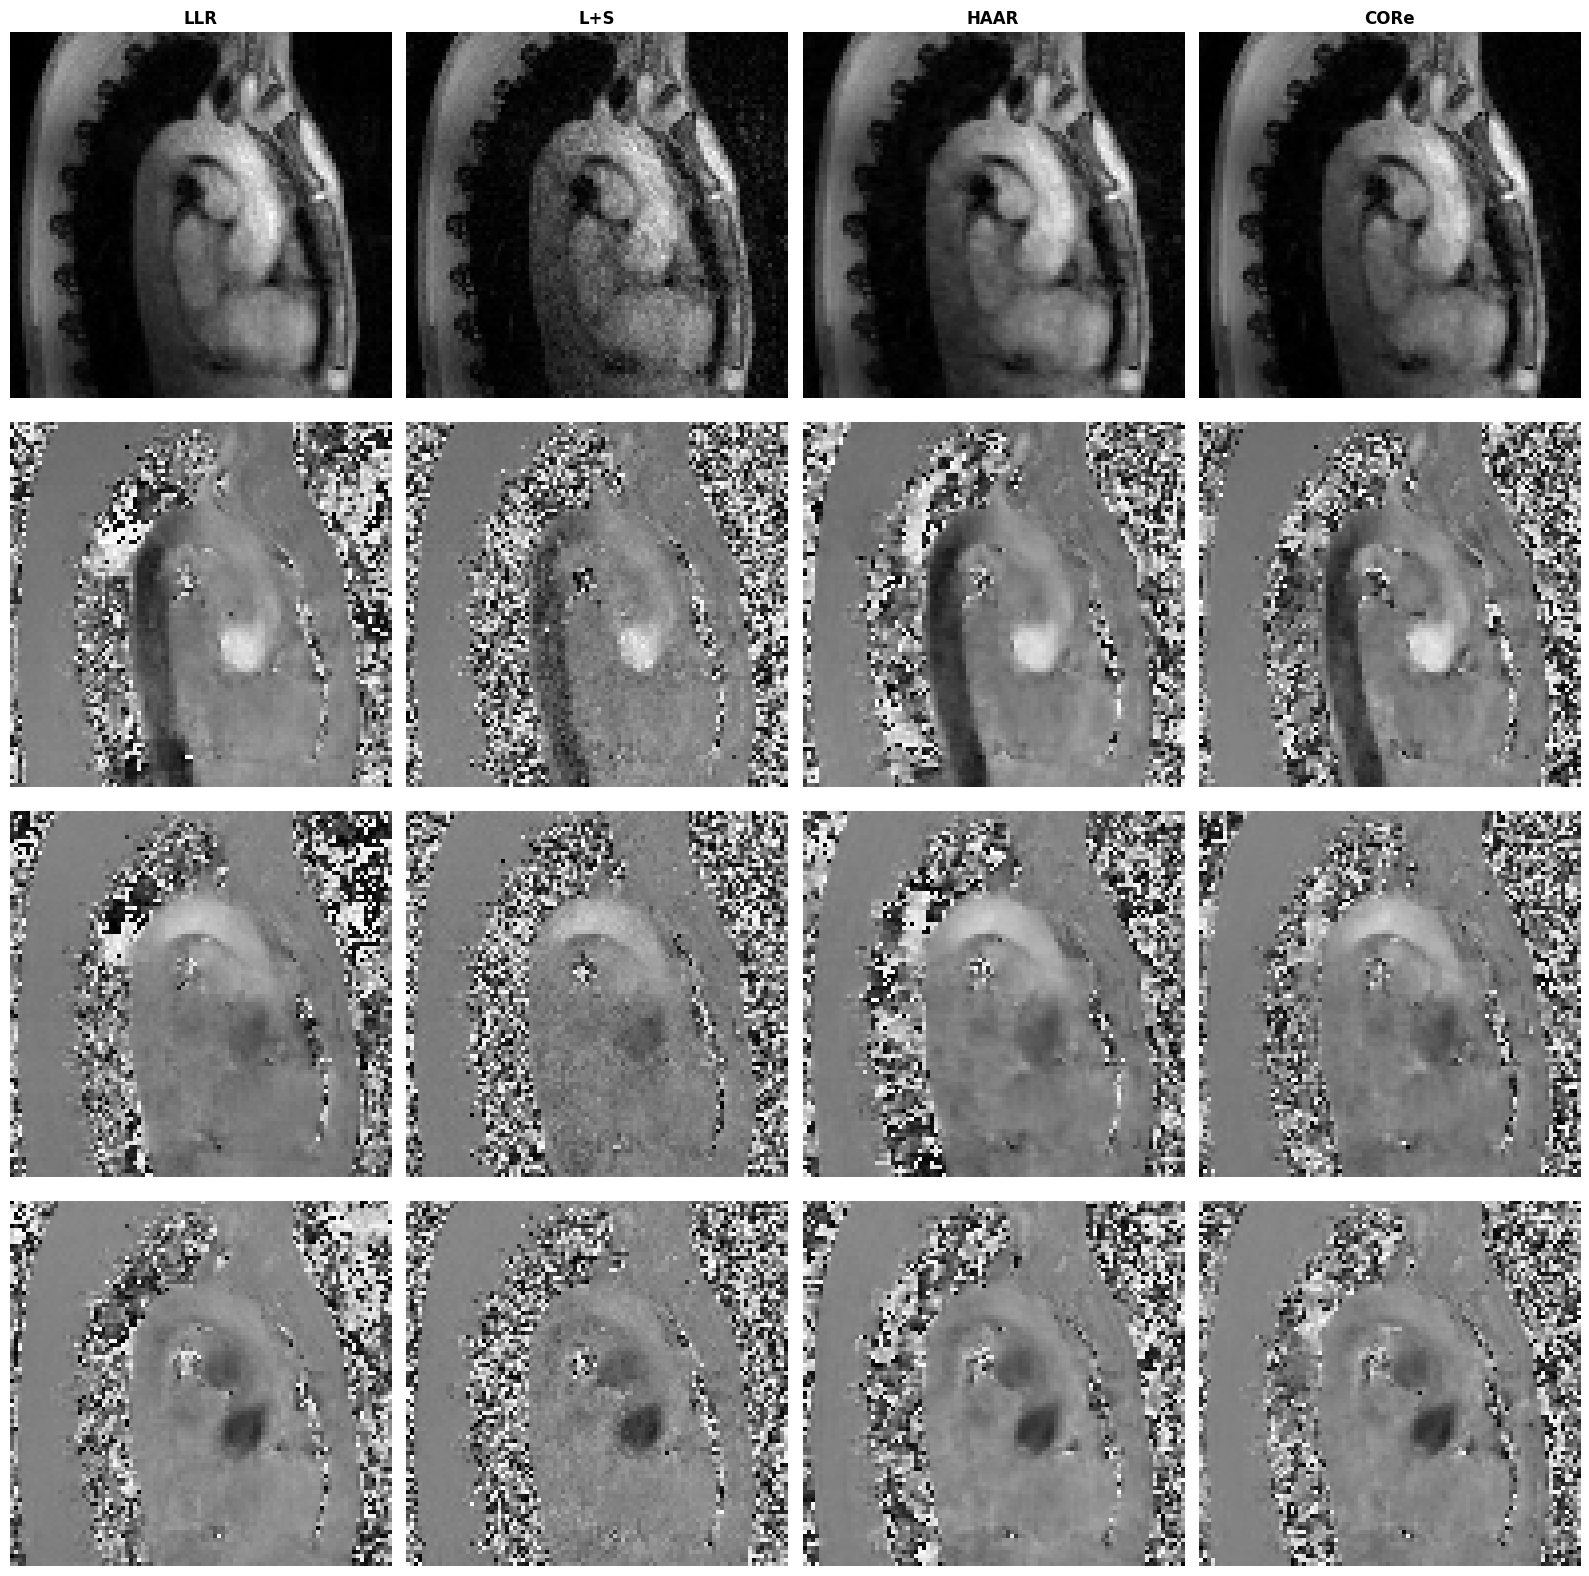

In [8]:
showt = 3
showz = 10
venc = 150
name_list = ['LLR', 'L+S', 'HAAR', 'CORe']
img_list = [img_llr, img_ls, img_haar, img_core]
flow_list = []
for i in range(4):
    img = img_list[i]
    flow = np.angle(img[1:] * np.conj(img[0:1])) / np.pi * venc
    flow_list.append(flow)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    img = img_list[i]
    axs[0, i].imshow(np.abs(img[0, showt, :, :, showz]), cmap='gray')
    axs[0, i].set_title(name_list[i], fontsize=12, fontweight='bold')
    axs[0, i].axis('off')
for i in range(4):
    flow = flow_list[i]
    axs[1, i].imshow(flow[0, showt, :, :, showz], cmap='gray', vmin=-venc, vmax=venc)
    axs[1, i].axis('off')
    axs[2, i].imshow(flow[1, showt, :, :, showz], cmap='gray', vmin=-venc, vmax=venc)
    axs[2, i].axis('off')
    axs[3, i].imshow(flow[2, showt, :, :, showz], cmap='gray', vmin=-venc, vmax=venc)
    axs[3, i].axis('off')
    
plt.tight_layout()
plt.show()